In [10]:
from commonfunctions import *




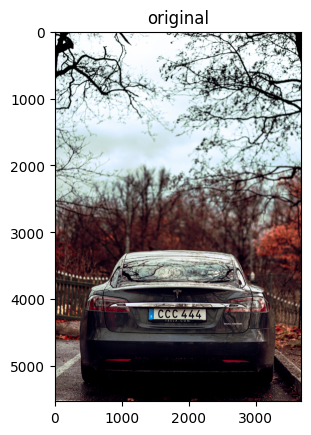

In [11]:
img = io.imread('images/3arabeya.jpg')
show_images([img], ['original'])    

In [14]:
img = rgb2gray(img)
img  = img * 255




ValueError: the input array must have size 3 along `channel_axis`, got (5526, 3684)